In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

import allantools as allan

Welcome to JupyROOT 6.12/04


In [111]:
tr3955 = gm2.Trolley([3957])
fp3955 = gm2.FixedProbe([3957])

tr_time, tr_phi, tr_freq = tr3955.getBasics(mode_phi=2)
tr_phi = np.rad2deg(np.unwrap(np.deg2rad(tr_phi)))
_, fp_time, fp_freq = fp3955.getBasics()
tr_time /= 1.0e9  # timestamps come in nanoseconds, convert to seconds
fp_time /= 1.0e9

tr_indices = np.arange(len(tr_freq)) >= 10  # drop first 10 trolley events
fp_indices = np.arange(len(fp_freq)) >= 3  # drop first 3 fixed probe events

tr_time = tr_time[tr_indices]
tr_phi = tr_phi[tr_indices]
tr_freq = tr_freq[tr_indices]
fp_time = fp_time[fp_indices]
fp_freq = fp_freq[fp_indices]

times = np.arange(np.ceil(np.max([tr_time[0, 16],
                                  fp_time[0, 377]])),
                  np.floor(np.min([fp_time[-1, 0],
                                   fp_time[-1, 0]])) + 1,
                  1)
t0 = np.min(times)

times = times - t0
tr_time = tr_time - t0
fp_time = fp_time - t0


time_edges = (times + np.roll(times,1))/2
time_edges[0] = times[0]
time_edges = np.append(time_edges, times[-1])

Reading event 5970/5972 99.97%   
loop done: 100%                                    
Reading event 1790/1792 99.89%   
loop done: 100%                                    


1993
359.97318994736713
0.028707188228054292


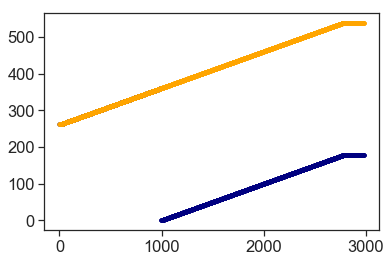

In [114]:
index = np.arange(tr_phi[1:,0].size)[np.abs(tr_phi[1:,0]-tr_phi[0:-1,0]) > 300]
index = int(index)
tr_phi_out = tr_phi[:,0].copy()
tr_phi_out[index+1:] = tr_phi_out[index+1:] + np.sign(tr_phi_out[index]-tr_phi_out[index+1])*360

fig, ax = plt.subplots(1,1)
plt.sca(ax)
plt.plot(tr_time[:,0], tr_phi[:,0], '.', color='navy')
plt.plot(tr_time[:,0], tr_phi_out, '.', color='orange')

In [94]:
%%time
# try using cumtrapz to integrate

# first make smaller grid (0.1 sec)

steps = 100
rate = 1./steps
offset = steps/2

integration_times = np.arange(times[0], times[-1], rate)


fp_freq_interp_cumtrapz = np.zeros([times.size, 378])
for probe in range(17):
    probe_interp = scipy.interpolate.interp1d(tr_time[:,probe], tr_freq[:,probe], kind='cubic')
    integration_points = probe_interp(integration_times)

    cumulative_integration = scipy.integrate.cumtrapz(integration_points, integration_times,
                                                     initial=0) + integration_points[0]

    indices = [steps*i + offset for i in range(integration_times.size/steps)]

    output = np.diff(cumulative_integration[indices])
    output = np.append(np.array([integration_points[0]]), output)
    output = np.append(output, np.array([integration_points[-1]]))
    
    fp_freq_interp_cumtrapz[:,probe] = output

CPU times: user 77 ms, sys: 1e+03 µs, total: 78 ms
Wall time: 141 ms


In [95]:
%%time

delta_ts = np.diff(time_edges)

# do the fixed_quad method over all 378 fixed probes
fp_freq_interp = np.zeros([times.size, 378])
for probe in np.arange(17):
    print '\r'+str(probe+1)+ ' of 378.',
    probe_interp = scipy.interpolate.interp1d(tr_time[:,probe], tr_freq[:,probe], kind='cubic')
    time_edges = (times + np.roll(times,1))/2
    time_edges[0] = times[0]
    time_edges = np.append(time_edges, times[-1])
    for t in np.arange(times.shape[0]):
        fp_freq_interp[t, probe], _ = scipy.integrate.fixed_quad(probe_interp, time_edges[t], time_edges[t+1], n=50)
        # n=50 for ppb level accuracy
#     fp_freq_interp[0,probe] *= 2
#     fp_freq_interp[-1,probe] *= 2
    fp_freq_interp[:,probe] /= delta_ts
print '\n'

17 of 378.    

CPU times: user 1.14 s, sys: 1e+03 µs, total: 1.14 s
Wall time: 1.14 s


(893, 378)


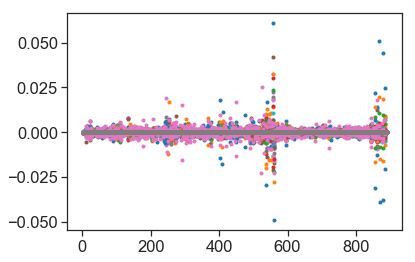

In [96]:
fig, ax = plt.subplots(1,1)
plt.sca(ax)
error = fp_freq_interp_cumtrapz - fp_freq_interp
print error.shape
_ = plt.plot(times[1:-1], error[1:-1,:], '.')

In [ ]:
%%time
# do the "standard" tr_phi interp

tr_phi_interp_1 = phi_interp(times)

In [ ]:
%%time
# do the fixed_quad integration method (VERY FAST, ~250 ms for n=100)

tr_phi_interp_2 = np.zeros([times.size, 1])
time_edges = (times + np.roll(times,1))/2
time_edges[0] = times[0]
time_edges = np.append(time_edges, times[-1])
for t in np.arange(times.shape[0]):
    print '\r'+str(t+1)+ ' of ' + str(times.shape[0]),
#     tr_phi_interp_2[t], _ = scipy.integrate.quad(phi_interp, time_edges[t], time_edges[t+1],
#                                                  epsabs=0, epsrel=1e-6)
    tr_phi_interp_2[t], _ = scipy.integrate.fixed_quad(phi_interp, time_edges[t], time_edges[t+1], n=50)
print '\n'
tr_phi_interp_2[0] *= 2
tr_phi_interp_2[-1] *= 2

# do the quad integration method (VERY SLOW, ~24 sec for epsrel=1e-9)

tr_phi_interp_3 = np.zeros([times.size, 1])
time_edges = (times + np.roll(times,1))/2
time_edges[0] = times[0]
time_edges = np.append(time_edges, times[-1])
for t in np.arange(times.shape[0]):
    print '\r'+str(t+1)+ ' of ' + str(times.shape[0]),
    tr_phi_interp_3[t], _ = scipy.integrate.quad(phi_interp, time_edges[t], time_edges[t+1],
                                                 epsabs=0, epsrel=1e-8)
print '\n'
tr_phi_interp_3[0] *= 2
tr_phi_interp_3[-1] *= 2

fig, ax = plt.subplots(1,1)
plt.sca(ax)
plt.plot(times, (tr_phi_interp_3 - tr_phi_interp_2)/tr_phi_interp_3)

fig.set_size_inches(12,4)
fig.tight_layout()

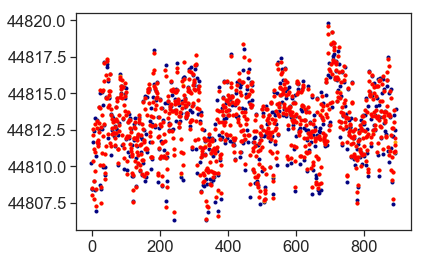

In [69]:
fig, ax = plt.subplots(1,1)
plt.sca(ax)

plt.plot(fp_time[:,0], fp_freq[:,0], '.', color='navy')
plt.plot(times, fp_freq_interp[:,0], '.', color='orange')
plt.plot(times, output, '.', color='red')


In [ ]:
%%time

probe = 6

rate = 1/(fp_time[100, probe] - fp_time[99,probe]) # data rate in Hz
# taus = np.exp2(np.arange(16)) #  tau-values in seconds
# taus = [1,2,4,8,16] #  tau-values in seconds

fig, ax = plt.subplots(2,1)

# adev for raw data
(taus_used, adev, adeverror, adev_n) = allan.oadev(fp_freq[:,probe], data_type='freq', rate=rate, taus='all')
plt.sca(ax[0])
plt.semilogx(taus_used, adev)

(taus_used, adev, adeverror, adev_n) = allan.oadev(fp_freq_interp[:,probe], data_type='freq', rate=1.0, taus='all')
plt.sca(ax[1])
plt.semilogx(taus_used, adev)
fig.set_size_inches(12,8)
fig.tight_layout()


In [ ]:
print fp_freq_interp.shape